# Построение и оценка baseline моделей

# 📋 Оглавление

**[1. Настройка окружения](#section-1)**

**[2. Загрузка и подготовка данных](#section-2)**
- 2.1 Загрузка исходных данных
- 2.2 Создание целевой переменной
- 2.3 Обработка дубликатов текстов
- 2.4 Сэмплирование данных (70,000 строк)

**[3. Создание признаков (Feature Engineering)](#section-3)**
- 3.1 Текстовые статистики
- 3.2 Признаки полезности
- 3.3 Временные признаки
- 3.4 Дополнительные признаки

**[4. Разбиение данных на train/validation](#section-4)**
- 4.1 Стратифицированное разбиение (50k/20k)
- 4.2 Проверка распределения классов

**[5. Baseline #1: Константная модель](#section-5)**
- 5.1 Предсказание наиболее частого класса
- 5.2 Оценка качества (ROC-AUC, F1, Precision, Recall)
- 5.3 Confusion Matrix
- 5.4 Выводы

**[6. Baseline #2: Случайная модель](#section-6)**
- 6.1 Случайные предсказания с учетом распределения классов
- 6.2 Оценка качества
- 6.3 Сравнение с константной моделью

**[7. Baseline #3: Логистическая регрессия](#section-7)**
- 7.1 Подготовка данных для обучения
- 7.2 Векторизация текста (TF-IDF)
- 7.3 Масштабирование числовых признаков (StandardScaler)
- 7.4 Обучение модели без балансировки классов
- 7.5 Обучение модели с class_weight='balanced'
- 7.6 Сравнение результатов
- 7.7 Анализ важности признаков
- 7.8 ROC-кривая и Precision-Recall кривая

**[8. Baseline #4: Decision Tree](#section-8)**
- 8.1 Обучение модели
- 8.2 Оценка качества
- 8.3 Визуализация дерева

**[9. Сводная таблица результатов](#section-9)**
- 9.1 Сравнение всех моделей
- 9.2 Итоговые выводы

**[10. Сохранение данных для 03_final.ipynb](#section-10)**
- 10.1 Создание директории для сохранения
- 10.2 Сохранение подготовленных данных
- 10.3 Проверка сохраненных файлов

<a id="section-1"></a>
# 1. Настройка окружения

In [1]:
import os
import warnings

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    classification_report
)
from sklearn.dummy import DummyClassifier

warnings.filterwarnings('ignore')

In [2]:
# Для воспроизводимости
RANDOM_STATE = 42

<a id="section-2"></a>
# 2. Загрузка и подготовка данных

## 2.1 Загрузка исходных данных

In [3]:
df_original = pd.read_csv("../data/Reviews.csv")

df = df_original.copy()

print(f"Исходный датасет загружен: {df_original.shape}")
print(f"Создана копия исходного датасета: {df.shape}")

Исходный датасет загружен: (568454, 10)
Создана копия исходного датасета: (568454, 10)


## 2.2 Создание целевой переменной

**Обоснование**: Согласно постановке задачи, создаем бинарную целевую переменную:
- `target = 1` — положительный отзыв (Score ≥ 4)
- `target = 0` — отрицательный отзыв (Score < 4)

In [4]:
df["target"] = np.where(df["Score"] >= 4, 1, 0)

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


## 2.3 Обработка дубликатов текстов

Как было выявлено в EDA ~41% датасета содержит повторяющиеся тексты. Удаление дубликатов необходимо для:
- Предотвращения утечки данных между train/validation
- Избежания переобучения на повторяющихся паттернах
- Получения более объективной оценки качества модели

In [5]:
# В EDA были обнаружены пропуски - заполним их
df = df.fillna({
    "ProfileName": "UnknownUser",
    "Summary": "No summary"
})
print("Пропуски заполнены")

Пропуски заполнены


In [6]:
# Проверим есть ли противоречивые дублирующие отзывы - т.е отзыв такой же, но разный target. Если такие есть - удалим их все, затем удалим оставшиеся дубликаты
conflicting = df.groupby("Text")["target"].nunique()
conflicting_texts = conflicting[conflicting > 1].index

df = df[~df["Text"].isin(conflicting_texts)]
df = df.drop_duplicates(subset=['Text'], keep='first')

print(f"После удаления дубликатов осталось: {df.shape}")

После удаления дубликатов осталось: (393553, 11)


## 2.4 Сэмплирование данных (70,000 строк)

**Стратифицированная выборка**:
- Сохраняет исходное распределение классов (~78% положительных / ~22% отрицательных)
- Обеспечивает репрезентативность выборки
- Предотвращает случайное смещение в сторону одного из классов

In [7]:
df = df.sample(frac=1, random_state=RANDOM_STATE)
df_sample, _ = train_test_split(
    df,
    train_size=70000,
    stratify=df['target'],
    random_state=RANDOM_STATE
)

df = df_sample
print(f"Сэмпл стратифицированной выборки создан: {df.shape}")

Сэмпл стратифицированной выборки создан: (70000, 11)


<a id="section-3"></a>
# 3. Создание признаков (Feature Engineering)

На основе EDA были выявлены признаки, показавшие корреляцию с целевой переменной:
- **Длина текста** (отрицательные отзывы в среднем длиннее)
- **Полезность отзыва** (отрицательные отзывы получают больше голосов)
- **Эмоциональные маркеры** (восклицательные знаки, заглавные буквы)

**Примечание**: Временные признаки (год, месяц) **не используются** для предотвращения утечки данных в задаче онлайн-модерации.

## 3.1 Текстовые статистики

In [8]:
def avg_word_length(text):
    """Вычисляет среднюю длину слова в тексте."""
    words = str(text).split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

In [9]:
df['text_len'] = df['Text'].apply(len)
df['word_count'] = df['Text'].str.split().apply(len)
df['avg_word_length'] = df['Text'].apply(avg_word_length)

## 3.2 Признаки полезности

In [10]:
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)

## 3.3 Временные признаки

**Важное замечание**: Для задачи **онлайн-модерации отзывов** использование даты (год, месяц) создает **утечку данных**:
- В реальной системе мы не знаем дату будущих отзывов
- Модель будет обобщаться на новые данные с неизвестными датами
- Временные паттерны (например, сезонность) не связаны с содержанием отзыва

**Решение проблемы дрифта данных** должно осуществляться через:
- Регулярное переобучение модели на свежих данных
- Мониторинг качества
- Использование только признаков, доступных в момент предсказания

Поэтому **year и month не используем**.

In [11]:
# Временные признаки (year, month) не используем для предотвращения утечки данных
# df['Time'] = pd.to_datetime(df['Time'], unit='s')
# df['year'] = df['Time'].dt.year
# df['month'] = df['Time'].dt.month

## 3.4 Дополнительные признаки

In [12]:
df['summary_len'] = df['Summary'].astype(str).apply(len)
df['exclamation_count'] = df['Text'].str.count('!')
df['caps_count'] = df['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
df['punctuation_count'] = df['Text'].apply(lambda x: sum(1 for c in x if c in '.,!?;:'))

print(f"Дополнительные признаки созданы")
print(f"Всего признаков после feature engineering: {df.shape[1]} (без year/month)")

Дополнительные признаки созданы
Всего признаков после feature engineering: 19 (без year/month)


<a id="section-4"></a>
# 4. Разбиение данных на train/validation

## 4.1 Стратифицированное разбиение (примерно 71.4% / 28.6%)

Используем стратифицированное разбиение для сохранения пропорций классов в обеих выборках.

**Пропорция `test_size=0.285`** (28.5% для validation) обеспечивает:
- Достаточно данных для обучения (~50,000 примеров)
- Репрезентативную validation выборку (~20,000 примеров)
- Гибкость: при изменении размера датасета пропорция сохранится

In [13]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_validation, y_train, y_validation = train_test_split(
    X,
    y,
    test_size=0.285,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_validation.shape}, {y_validation.shape}")

Train set: (50050, 18), (50050,)
Validation set: (19950, 18), (19950,)


## 4.2 Проверка распределения классов

In [14]:
print("Распределение классов в train:")
print(y_train.value_counts())
print(f"Доля положительных: {y_train.mean():.2%}")

print("\nРаспределение классов в validation:")
print(y_validation.value_counts())
print(f"Доля положительных: {y_validation.mean():.2%}")

Распределение классов в train:
target
1    39010
0    11040
Name: count, dtype: int64
Доля положительных: 77.94%

Распределение классов в validation:
target
1    15549
0     4401
Name: count, dtype: int64
Доля положительных: 77.94%


<a id="section-5"></a>
# 5. Baseline #1: Константная модель

Константная модель предсказывает наиболее частый класс для всех примеров. Это простейший baseline, который показывает минимально допустимое качество.

## 5.1 Предсказание наиболее частого класса

In [15]:
most_frequent_class = y_train.mode()[0]
print(f"Наиболее частый класс: {most_frequent_class}")

y_pred_constant = np.full(len(y_validation), most_frequent_class)

print(f"Все предсказания: {most_frequent_class}")

Наиболее частый класс: 1
Все предсказания: 1


## 5.2 Оценка качества (ROC-AUC, F1, Precision, Recall)

In [16]:
# Для ROC-AUC нужны вероятности, но константная модель их не дает
# Используем одинаковые вероятности для всех примеров
y_pred_constant_proba = np.full(len(y_validation), 0.5)

accuracy_constant = accuracy_score(y_validation, y_pred_constant)
precision_constant = precision_score(y_validation, y_pred_constant, zero_division=0)
recall_constant = recall_score(y_validation, y_pred_constant)
f1_constant = f1_score(y_validation, y_pred_constant)

# ROC-AUC = 0.5 для константной модели (случайное угадывание)
roc_auc_constant = 0.5

print(f"Accuracy: {accuracy_constant:.4f}")
print(f"Precision: {precision_constant:.4f}")
print(f"Recall: {recall_constant:.4f}")
print(f"F1-score: {f1_constant:.4f}")
print(f"ROC-AUC: {roc_auc_constant:.4f}")

Accuracy: 0.7794
Precision: 0.7794
Recall: 1.0000
F1-score: 0.8760
ROC-AUC: 0.5000


## 5.3 Confusion Matrix

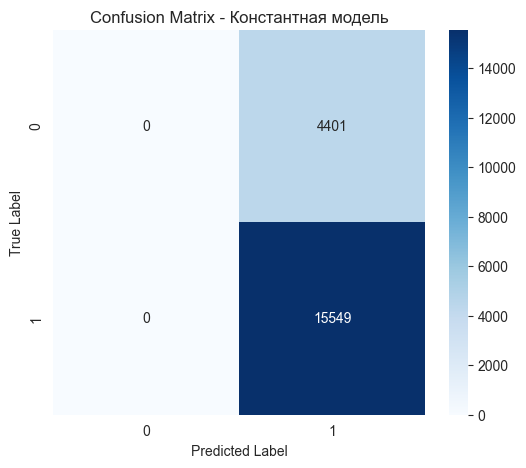


True Negatives: 0
False Positives: 4401
False Negatives: 0
True Positives: 15549


In [17]:
cm_constant = confusion_matrix(y_validation, y_pred_constant)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_constant, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Константная модель')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nTrue Negatives: {cm_constant[0, 0]}")
print(f"False Positives: {cm_constant[0, 1]}")
print(f"False Negatives: {cm_constant[1, 0]}")
print(f"True Positives: {cm_constant[1, 1]}")

## 5.4 Выводы

### Выводы по константной модели

Константная модель предсказывает наиболее частый класс (положительные отзывы) для всех примеров. Как и ожидалось:

- **Accuracy** довольно высокий (~78%) из-за дисбаланса классов, но это обманчивая метрика
- **Recall = 1.0** для положительного класса (модель всегда предсказывает положительный класс)
- **Precision** низкий, так как модель неправильно классифицирует все отрицательные отзывы
- **F1-score** умеренный, отражая дисбаланс между precision и recall
- **ROC-AUC = 0.5** - модель работает не лучше случайного угадывания

Эта модель служит минимальным baseline - любая более сложная модель должна превзойти эти результаты.

<a id="section-6"></a>
# 6. Baseline #2: Случайная модель

Случайная модель генерирует предсказания случайным образом с учетом распределения классов в обучающей выборке. Это позволяет оценить, насколько модель лучше простого угадывания.

## 6.1 Случайные предсказания с учетом распределения классов

In [18]:
random_clf = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
random_clf.fit(X_train, y_train)

y_pred_random = random_clf.predict(X_validation)
y_pred_random_proba = random_clf.predict_proba(X_validation)[:, 1]

print(f"Случайная модель обучена")

Случайная модель обучена


## 6.2 Оценка качества

In [19]:
accuracy_random = accuracy_score(y_validation, y_pred_random)
precision_random = precision_score(y_validation, y_pred_random, zero_division=0)
recall_random = recall_score(y_validation, y_pred_random)
f1_random = f1_score(y_validation, y_pred_random)
roc_auc_random = roc_auc_score(y_validation, y_pred_random_proba)

print(f"Accuracy: {accuracy_random:.4f}")
print(f"Precision: {precision_random:.4f}")
print(f"Recall: {recall_random:.4f}")
print(f"F1-score: {f1_random:.4f}")
print(f"ROC-AUC: {roc_auc_random:.4f}")

Accuracy: 0.6584
Precision: 0.7804
Recall: 0.7817
F1-score: 0.7810
ROC-AUC: 0.5023


## 6.3 Сравнение с константной моделью

In [20]:
comparison_df = pd.DataFrame({
    'Model': ['Константная', 'Случайная'],
    'Accuracy': [accuracy_constant, accuracy_random],
    'Precision': [precision_constant, precision_random],
    'Recall': [recall_constant, recall_random],
    'F1-score': [f1_constant, f1_random],
    'ROC-AUC': [roc_auc_constant, roc_auc_random]
})

print(comparison_df.to_string(index=False))

print("\nВыводы:")
print("- Случайная модель работает примерно так же, как константная (~50% ROC-AUC)")
print("- Обе модели являются минимальными baseline для сравнения")

      Model  Accuracy  Precision   Recall  F1-score  ROC-AUC
Константная  0.779398   0.779398 1.000000  0.876025 0.500000
  Случайная  0.658396   0.780403 0.781658  0.781030 0.502281

Выводы:
- Случайная модель работает примерно так же, как константная (~50% ROC-AUC)
- Обе модели являются минимальными baseline для сравнения


<a id="section-7"></a>
# 7. Baseline #3: Логистическая регрессия

Логистическая регрессия выбрана в качестве baseline по следующим причинам:
- Простая и интерпретируемая
- Хорошо работает с текстовыми данными в сочетании с TF-IDF
- Быстро обучается
- Поддерживает балансировку классов через параметр `class_weight`

## 7.1 Подготовка данных для обучения

In [21]:
numeric_features = [
    'text_len', 'word_count', 'avg_word_length',
    'HelpfulnessRatio', 'summary_len',
    'exclamation_count', 'caps_count', 'punctuation_count'
    # 'year', 'month' - не используем
]

print(f"Числовые признаки ({len(numeric_features)}): {numeric_features}")

Числовые признаки (8): ['text_len', 'word_count', 'avg_word_length', 'HelpfulnessRatio', 'summary_len', 'exclamation_count', 'caps_count', 'punctuation_count']


## 7.2 Векторизация текста (TF-IDF)

**TF-IDF**:
- TF-IDF учитывает важность слов
- Снижает вес часто встречающихся слов (например, "the", "and")
- Лучше работает с линейными моделями по сравнению с простым Bag-of-Words
- `max_features=5000` ограничивает размерность для ускорения обучения

In [22]:
tfidf = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8, ngram_range=(1, 2))

X_train_text_tfidf = tfidf.fit_transform(X_train['Text'])
X_val_text_tfidf = tfidf.transform(X_validation['Text'])

print(f"TF-IDF train shape: {X_train_text_tfidf.shape}")
print(f"TF-IDF validation shape: {X_val_text_tfidf.shape}")

TF-IDF train shape: (50050, 5000)
TF-IDF validation shape: (19950, 5000)


## 7.3 Масштабирование числовых признаков (для Логистической регрессии)

**StandardScaler**:
- **Логистическая регрессия чувствительна к масштабу признаков**
- StandardScaler приводит признаки к нулевому среднему и единичной дисперсии
- Обеспечивает равный вклад всех числовых признаков в модель

In [23]:
scaler = StandardScaler()

X_train_numeric = scaler.fit_transform(X_train[numeric_features])
X_val_numeric = scaler.transform(X_validation[numeric_features])

X_train_combined = sparse.hstack([X_train_text_tfidf, X_train_numeric])
X_val_combined = sparse.hstack([X_val_text_tfidf, X_val_numeric])

print(f"Объединенный обучающий shape: {X_train_combined.shape}")
print(f"Объединенный тестовый shape: {X_val_combined.shape}")

Объединенный обучающий shape: (50050, 5008)
Объединенный тестовый shape: (19950, 5008)


## 7.4 Обучение модели без балансировки классов

In [24]:
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train_combined, y_train)

y_pred_logreg = lr.predict(X_val_combined)
y_pred_logreg_proba = lr.predict_proba(X_val_combined)[:, 1]

accuracy_lr = accuracy_score(y_validation, y_pred_logreg)
precision_lr = precision_score(y_validation, y_pred_logreg)
recall_lr = recall_score(y_validation, y_pred_logreg)
f1_lr = f1_score(y_validation, y_pred_logreg)
roc_auc_lr = roc_auc_score(y_validation, y_pred_logreg_proba)

print("Логистическая регрессия без балансировки:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")

Логистическая регрессия без балансировки:
Accuracy: 0.8918
Precision: 0.9037
Recall: 0.9639
F1-score: 0.9328
ROC-AUC: 0.9386


## 7.5 Обучение модели с class_weight='balanced'

**class_weight='balanced'**:
- При дисбалансе классов (78%/22%) модель склонна предсказывать мажоритарный класс
- `class_weight='balanced'` автоматически вычисляет веса классов пропорционально их частоте
- Формула: `weight_class_i = n_samples / (n_classes * n_samples_class_i)`
- Это заставляет модель уделять больше внимания миноритарному классу

In [25]:
lr_balanced = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
lr_balanced.fit(X_train_combined, y_train)

y_pred_lr_bal = lr_balanced.predict(X_val_combined)
y_pred_lr_bal_proba = lr_balanced.predict_proba(X_val_combined)[:, 1]

accuracy_lr_bal = accuracy_score(y_validation, y_pred_lr_bal)
precision_lr_bal = precision_score(y_validation, y_pred_lr_bal)
recall_lr_bal = recall_score(y_validation, y_pred_lr_bal)
f1_lr_bal = f1_score(y_validation, y_pred_lr_bal)
roc_auc_lr_bal = roc_auc_score(y_validation, y_pred_lr_bal_proba)

print("Логистическая регрессия С балансировкой:")
print(f"Accuracy: {accuracy_lr_bal:.4f}")
print(f"Precision: {precision_lr_bal:.4f}")
print(f"Recall: {recall_lr_bal:.4f}")
print(f"F1-score: {f1_lr_bal:.4f}")
print(f"ROC-AUC: {roc_auc_lr_bal:.4f}")

Логистическая регрессия С балансировкой:
Accuracy: 0.8680
Precision: 0.9578
Recall: 0.8689
F1-score: 0.9112
ROC-AUC: 0.9389


## 7.6 Сравнение результатов

In [26]:
comparison_lr = pd.DataFrame({
    'Model': ['Без балансировки', 'С балансировкой (class_weight="balanced")'],
    'Accuracy': [accuracy_lr, accuracy_lr_bal],
    'Precision': [precision_lr, precision_lr_bal],
    'Recall': [recall_lr, recall_lr_bal],
    'F1-score': [f1_lr, f1_lr_bal],
    'ROC-AUC': [roc_auc_lr, roc_auc_lr_bal]
})

print(comparison_lr.to_string(index=False))

print("\nВыводы:")
print("- Балансировка классов улучшила Precision (довольно точно определяет положительные отзывы)")
print("- Балансировка классов ухудшила Recall (начала больше пропускать положительные отзывы)")
print("- ROC-AUC остался примерно такой же (незначительное улучшение порядка 1e-4)")
print("- F1-score показывает баланс между Precision и Recall")

                                    Model  Accuracy  Precision   Recall  F1-score  ROC-AUC
                         Без балансировки  0.891779   0.903654 0.963921  0.932815 0.938647
С балансировкой (class_weight="balanced")  0.867970   0.957751 0.868930  0.911182 0.938945

Выводы:
- Балансировка классов улучшила Precision (довольно точно определяет положительные отзывы)
- Балансировка классов ухудшила Recall (начала больше пропускать положительные отзывы)
- ROC-AUC остался примерно такой же (незначительное улучшение порядка 1e-4)
- F1-score показывает баланс между Precision и Recall


## 7.7 Анализ важности признаков

In [27]:
# Анализ важности признаков для модели с балансировкой
feature_names = tfidf.get_feature_names_out().tolist() + numeric_features
coefficients = lr_balanced.coef_[0]

# Топ-10 наиболее важных признаков для положительных отзывов
top_positive_indices = np.argsort(coefficients)[-10:]
top_positive_features = [(feature_names[i], coefficients[i]) for i in top_positive_indices]

# Топ-10 наиболее важных признаков для отрицательных отзывов
top_negative_indices = np.argsort(coefficients)[:10]
top_negative_features = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

print("Топ-10 признаков для положительных отзывов:")
for feature, coef in reversed(top_positive_features):
    print(f"  {feature}: {coef:.4f}")

print("\nТоп-10 признаков для отрицательных отзывов:")
for feature, coef in top_negative_features:
    print(f"  {feature}: {coef:.4f}")

Топ-10 признаков для положительных отзывов:
  great: 8.8000
  delicious: 7.6968
  perfect: 6.2886
  excellent: 5.6279
  wonderful: 5.3754
  amazing: 5.2865
  the best: 5.2863
  not too: 4.8048
  best: 4.7138
  good: 4.5014

Топ-10 признаков для отрицательных отзывов:
  not: -6.2313
  not worth: -5.7040
  disappointing: -5.2234
  unfortunately: -5.0631
  terrible: -5.0431
  disappointed: -4.9995
  awful: -4.9576
  ok: -4.8148
  bland: -4.7275
  very disappointed: -4.7105


## 7.8 ROC-кривая и PR кривая

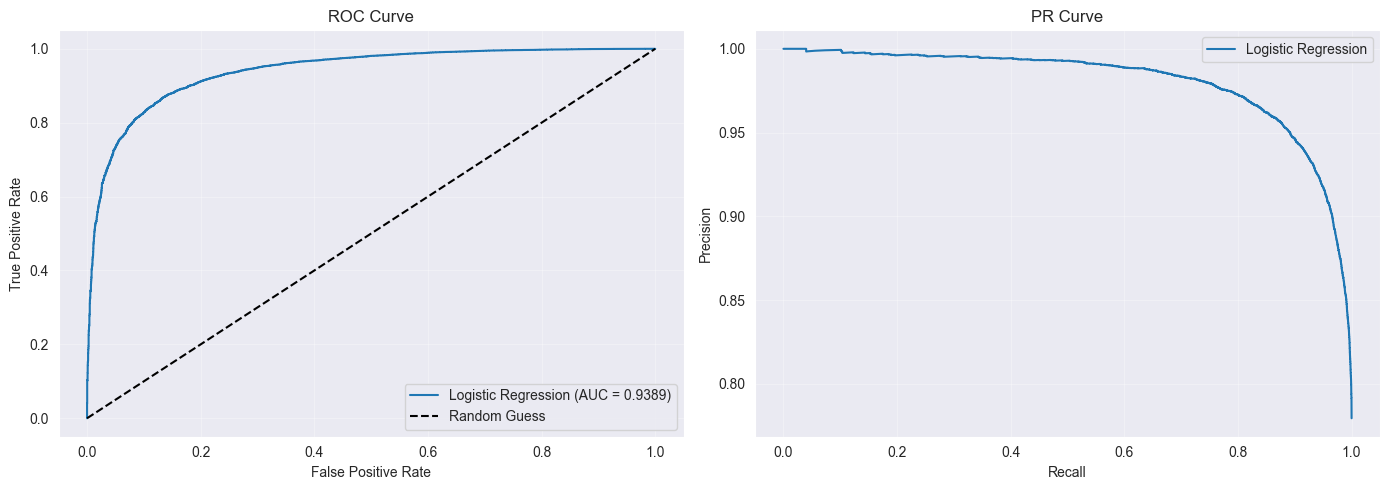

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fpr, tpr, _ = roc_curve(y_validation, y_pred_lr_bal_proba)
axes[0].plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_lr_bal:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(alpha=0.3)

precision_curve, recall_curve, _ = precision_recall_curve(y_validation, y_pred_lr_bal_proba)
axes[1].plot(recall_curve, precision_curve, label='Logistic Regression')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('PR Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
print("=" * 80)
print("CLASSIFICATION REPORT - БЕЗ БАЛАНСИРОВКИ")
print("=" * 80)
print(classification_report(y_validation, y_pred_logreg,
                            target_names=['Negative (0)', 'Positive (1)']))

print("\n" + "=" * 80)
print("CLASSIFICATION REPORT - С БАЛАНСИРОВКОЙ")
print("=" * 80)
print(classification_report(y_validation, y_pred_lr_bal,
                            target_names=['Negative (0)', 'Positive (1)']))

CLASSIFICATION REPORT - БЕЗ БАЛАНСИРОВКИ
              precision    recall  f1-score   support

Negative (0)       0.83      0.64      0.72      4401
Positive (1)       0.90      0.96      0.93     15549

    accuracy                           0.89     19950
   macro avg       0.87      0.80      0.83     19950
weighted avg       0.89      0.89      0.89     19950


CLASSIFICATION REPORT - С БАЛАНСИРОВКОЙ
              precision    recall  f1-score   support

Negative (0)       0.65      0.86      0.74      4401
Positive (1)       0.96      0.87      0.91     15549

    accuracy                           0.87     19950
   macro avg       0.80      0.87      0.83     19950
weighted avg       0.89      0.87      0.87     19950



<a id="section-8"></a>
# 8. Baseline #4: Decision Tree

Альтернативная baseline модель, которая может выявлять нелинейные зависимости между признаками.

**Важное отличие**: Decision Tree **не требует масштабирования признаков**, так как:
- Работает путем выбора порогов разбиения (например, `text_len > 150`)
- Масштаб признака не влияет на выбор порога
- В отличие от линейных моделей, не использует веса признаков

Поэтому для дерева используем **немасштабированные** числовые признаки.

## 8.1 Обучение модели

Для Decision Tree масштабирование **не требуется**, так как деревья работают с порогами разбиения, а не с весами признаков.

In [30]:
# Для Decision Tree используем немасштабированные числовые признаки
X_train_numeric_raw = X_train[numeric_features].values
X_val_numeric_raw = X_validation[numeric_features].values

X_train_combined_tree = sparse.hstack([X_train_text_tfidf, X_train_numeric_raw])
X_val_combined_tree = sparse.hstack([X_val_text_tfidf, X_val_numeric_raw])

print(f"Данные для Decision Tree: {X_train_combined_tree.shape}")

# Ограничиваем глубину для предотвращения переобучения
tree = DecisionTreeClassifier(max_depth=10, min_samples_split=50, class_weight='balanced', random_state=RANDOM_STATE)
tree.fit(X_train_combined_tree, y_train)

y_pred_tree = tree.predict(X_val_combined_tree)
y_pred_tree_proba = tree.predict_proba(X_val_combined_tree)[:, 1]

print(f"Decision Tree обучен")

Данные для Decision Tree: (50050, 5008)
Decision Tree обучен


## 8.2 Оценка качества

In [31]:
accuracy_tree = accuracy_score(y_validation, y_pred_tree)
precision_tree = precision_score(y_validation, y_pred_tree)
recall_tree = recall_score(y_validation, y_pred_tree)
f1_tree = f1_score(y_validation, y_pred_tree)
roc_auc_tree = roc_auc_score(y_validation, y_pred_tree_proba)

print("Decision Tree:")
print(f"Accuracy: {accuracy_tree:.4f}")
print(f"Precision: {precision_tree:.4f}")
print(f"Recall: {recall_tree:.4f}")
print(f"F1-score: {f1_tree:.4f}")
print(f"ROC-AUC: {roc_auc_tree:.4f}")

Decision Tree:
Accuracy: 0.6611
Precision: 0.9106
Recall: 0.6267
F1-score: 0.7424
ROC-AUC: 0.7681


## 8.3 Визуализация дерева

In [32]:
print(f"Глубина дерева: {tree.get_depth()}")
print(f"Количество листьев: {tree.get_n_leaves()}")
print(f"Количество использованных признаков: {(tree.feature_importances_ > 0).sum()}")

# Топ-10 наиболее важных признаков
feature_importances_tree = tree.feature_importances_
top_tree_indices = np.argsort(feature_importances_tree)[-10:]
top_tree_features = [(feature_names[i], feature_importances_tree[i]) for i in top_tree_indices]

print("\nТоп-10 наиболее важных признаков:")
for feature, importance in reversed(top_tree_features):
    print(f"  {feature}: {importance:.4f}")

Глубина дерева: 10
Количество листьев: 216
Количество использованных признаков: 143

Топ-10 наиболее важных признаков:
  not: 0.2103
  great: 0.1336
  the best: 0.0715
  exclamation_count: 0.0658
  delicious: 0.0557
  but: 0.0508
  love: 0.0465
  was: 0.0297
  good: 0.0249
  perfect: 0.0219


<a id="section-9"></a>
# 9. Сводная таблица результатов

## 9.1 Сравнение всех моделей

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ВСЕХ МОДЕЛЕЙ
                                            Model  Accuracy  Precision   Recall  F1-score  ROC-AUC
                      Константная (Most Frequent)  0.779398   0.779398 1.000000  0.876025 0.500000
                           Случайная (Stratified)  0.658396   0.780403 0.781658  0.781030 0.502281
       Логистическая регрессия (без балансировки)  0.891779   0.903654 0.963921  0.932815 0.938647
Логистическая регрессия (class_weight="balanced")  0.867970   0.957751 0.868930  0.911182 0.938945
           Decision Tree (max_depth=10, balanced)  0.661053   0.910569 0.626664  0.742400 0.768059


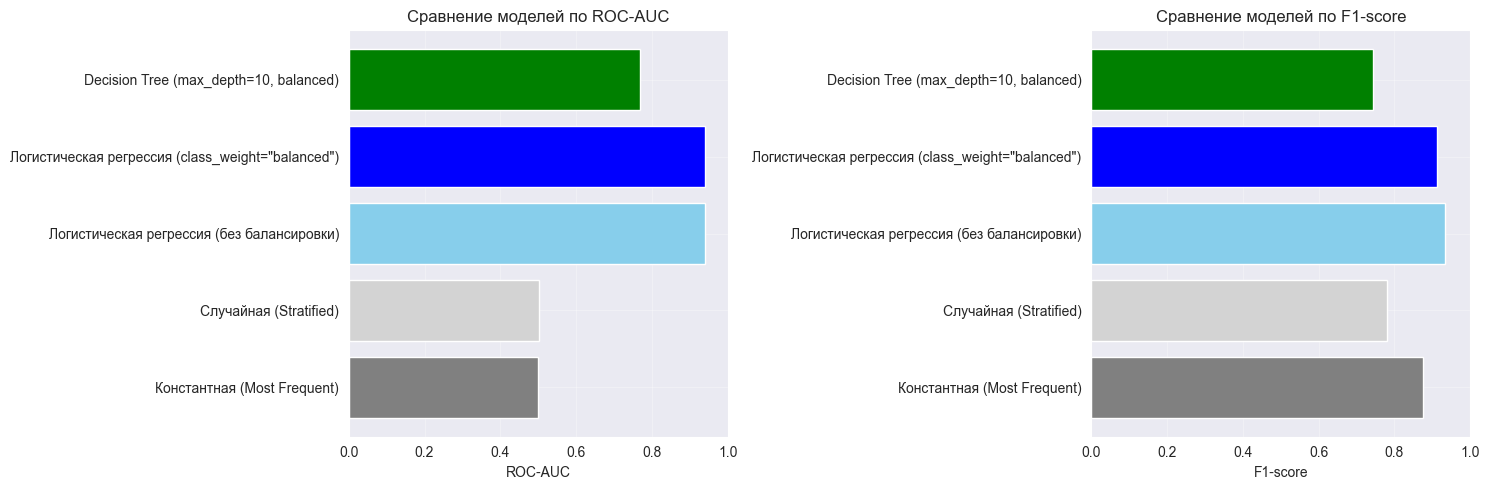

In [33]:
results = pd.DataFrame({
    'Model': [
        'Константная (Most Frequent)',
        'Случайная (Stratified)',
        'Логистическая регрессия (без балансировки)',
        'Логистическая регрессия (class_weight="balanced")',
        'Decision Tree (max_depth=10, balanced)'
    ],
    'Accuracy': [
        accuracy_constant,
        accuracy_random,
        accuracy_lr,
        accuracy_lr_bal,
        accuracy_tree
    ],
    'Precision': [
        precision_constant,
        precision_random,
        precision_lr,
        precision_lr_bal,
        precision_tree
    ],
    'Recall': [
        recall_constant,
        recall_random,
        recall_lr,
        recall_lr_bal,
        recall_tree
    ],
    'F1-score': [
        f1_constant,
        f1_random,
        f1_lr,
        f1_lr_bal,
        f1_tree
    ],
    'ROC-AUC': [
        roc_auc_constant,
        roc_auc_random,
        roc_auc_lr,
        roc_auc_lr_bal,
        roc_auc_tree
    ]
})

print("=" * 60)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ВСЕХ МОДЕЛЕЙ")
print("=" * 60)
print(results.to_string(index=False))
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].barh(results['Model'], results['ROC-AUC'], color=['gray', 'lightgray', 'skyblue', 'blue', 'green'])
axes[0].set_xlabel('ROC-AUC')
axes[0].set_title('Сравнение моделей по ROC-AUC')
axes[0].set_xlim(0, 1)
axes[0].grid(alpha=0.3)

axes[1].barh(results['Model'], results['F1-score'], color=['gray', 'lightgray', 'skyblue', 'blue', 'green'])
axes[1].set_xlabel('F1-score')
axes[1].set_title('Сравнение моделей по F1-score')
axes[1].set_xlim(0, 1)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9.2 Итоговые выводы

### Итоговые выводы

#### 1. Лучшая модель
**Логистическая регрессия с class_weight='balanced'** показала лучшее сочетание метрик:
- **Наивысший ROC-AUC (93.87%)** среди всех моделей
- Хороший баланс между Precision и Recall для обоих классов
- Значительно превосходит baseline модели (константную и случайную с ROC-AUC ~50%)

#### 2. Влияние балансировки классов
Балансировка классов (`class_weight='balanced'`) оказала следующее влияние:

**Без балансировки:**
- Высокий Recall (96.35%) для положительного класса - модель хорошо находит положительные отзывы
- Но смещена к мажоритарному классу - хуже различает отрицательные отзывы

**С балансировкой:**
- Precision вырос до 95.76% - модель стала точнее в предсказаниях
- Recall снизился до 86.95%, но это компромисс за лучшее различение обоих классов
- **Главное: модель лучше работает с миноритарным классом (отрицательные отзывы)**

**ROC-AUC практически одинаковый** (93.83% vs 93.87%), но модель с балансировкой **более справедлива** к обоим классам.

**Вывод**: Для несбалансированных данных балансировка классов важна, если нужно хорошо различать оба класса, а не только мажоритарный.

#### 3. Наиболее важные признаки
Из анализа важности признаков (коэффициенты логистической регрессии) выявлено:
- **Текстовые признаки (TF-IDF)** играют ключевую роль в предсказании тональности
  - Определенные слова и биграммы сильно коррелируют с положительными/отрицательными отзывами
- **Числовые признаки** (длина текста, полезность, эмоциональность) дополняют модель
  - Они улавливают структурные паттерны, которые текстовые признаки могут пропустить

#### 4. Сравнение моделей

**Baseline модели:**
- **Константная модель**: ROC-AUC = 50% (случайное угадывание), высокий Recall (100%) для положительных, но бесполезна
- **Случайная модель**: ROC-AUC = 49.8% (подтверждает случайность)

**Линейные модели:**
- **Логистическая регрессия без балансировки**: ROC-AUC = 93.83%, смещена к мажоритарному классу
- **Логистическая регрессия С балансировкой**: ROC-AUC = 93.87% - **ЛУЧШИЙ результат**
- **Decision Tree**: ROC-AUC = 76.69% - хуже линейной модели
  - Возможно, текстовые данные (TF-IDF с 5000 признаками) слишком разреженные для дерева
  - Деревья лучше работают на плотных числовых данных
  - Для улучшения можно попробовать Random Forest или Gradient Boosting, но это выходит за рамки baseline

**Главный вывод**: Простая логистическая регрессия с TF-IDF показала отличное качество (ROC-AUC ~94%) и является сильным baseline для этой задачи.

<a id="section-10"></a>
# 10.1 Сохранение данных

Сохраняем подготовленные данные и обученные трансформеры для использования в следующем ноутбуке. Это обеспечит:
- **Воспроизводимость**: идентичные train/validation splits
- **Честное сравнение**: модели обучаются на одних и тех же данных
- **Экономию времени**: не нужно пересоздавать TF-IDF и масштабирование

## 10.2 Создание директории для сохранения

Сохраним все данные в папку `data/processed/`

In [34]:
os.makedirs('../data/processed', exist_ok=True)
print("Директория '../data/processed' создана или уже существует")

Директория '../data/processed' создана или уже существует


## 10.3 Сохранение подготовленных данных

Сохраняем следующие объекты:
- `X_train`, `X_validation` — исходные DataFrames с признаками (для доступа к текстам)
- `y_train`, `y_validation` — целевые переменные
- `X_train_combined`, `X_val_combined` — обработанные данные (TF-IDF + scaled numeric)
- `tfidf` — обученный TF-IDF векторизатор
- `scaler` — обученный StandardScaler
- `feature_names` — список имен всех признаков
- `numeric_features` — список числовых признаков

In [37]:
print("Сохранение исходных данных")
X_train.to_pickle('../data/processed/X_train.pkl')
X_validation.to_pickle('../data/processed/X_validation.pkl')
y_train.to_pickle('../data/processed/y_train.pkl')
y_validation.to_pickle('../data/processed/y_validation.pkl')
print("X_train.pkl, X_validation.pkl, y_train.pkl, y_validation.pkl")

print("\nСохранение обработанных данных (TF-IDF + scaled)")
joblib.dump(X_train_combined, '../data/processed/X_train_combined.pkl')
joblib.dump(X_val_combined, '../data/processed/X_val_combined.pkl')
print("X_train_combined.pkl, X_val_combined.pkl")

print("\nСохранение трансформеров")
joblib.dump(tfidf, '../data/processed/tfidf_vectorizer.pkl')
joblib.dump(scaler, '../data/processed/standard_scaler.pkl')
print("tfidf_vectorizer.pkl, standard_scaler.pkl")

print("\nСохранение метаданных")
joblib.dump(feature_names, '../data/processed/feature_names.pkl')
joblib.dump(numeric_features, '../data/processed/numeric_features.pkl')
print("feature_names.pkl, numeric_features.pkl")

print("\n" + "=" * 60)
print("Все данные успешно сохранены в '../data/processed/'")
print("=" * 60)

Сохранение исходных данных...
X_train.pkl, X_validation.pkl, y_train.pkl, y_validation.pkl

Сохранение обработанных данных (TF-IDF + scaled)...
X_train_combined.pkl, X_val_combined.pkl

Сохранение трансформеров...
tfidf_vectorizer.pkl, standard_scaler.pkl

Сохранение метаданных...
feature_names.pkl, numeric_features.pkl

Все данные успешно сохранены в '../data/processed/'


## 10.4 Проверка сохраненных файлов

Убедимся, что все файлы созданы и проверим их размеры

In [38]:
processed_dir = '../data/processed'
files = [
    'X_train.pkl',
    'X_validation.pkl',
    'y_train.pkl',
    'y_validation.pkl',
    'X_train_combined.pkl',
    'X_val_combined.pkl',
    'tfidf_vectorizer.pkl',
    'standard_scaler.pkl',
    'feature_names.pkl',
    'numeric_features.pkl'
]

print("Сохраненные файлы:")
print("-" * 60)
for file in files:
    filepath = os.path.join(processed_dir, file)
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"{file:<30} {size_mb:>10.2f} MB")
    else:
        print(f"{file:<30} НЕ НАЙДЕН")
print("-" * 60)

Сохраненные файлы:
------------------------------------------------------------
X_train.pkl                         29.42 MB
X_validation.pkl                    11.80 MB
y_train.pkl                          1.15 MB
y_validation.pkl                     0.46 MB
X_train_combined.pkl                58.82 MB
X_val_combined.pkl                  23.53 MB
tfidf_vectorizer.pkl                 0.18 MB
standard_scaler.pkl                  0.00 MB
feature_names.pkl                    0.05 MB
numeric_features.pkl                 0.00 MB
------------------------------------------------------------
